# Manual labeling of patches

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import csv
import pandas as pd
import xarray as xr
from tqdm import tqdm

In [ ]:
# Load the patches (as array)

patches = np.load('/home/ubuntu/mucilage_pipeline/patches_total.npy')
N = patches.shape[0]

## Functions

In [3]:
def load_patch_from_coords(zarr_path, x, y, bands, patch_size=256):
    ds = xr.open_datatree(zarr_path, engine="zarr", mask_and_scale=False, chunks={})
    stack = build_stack_10m(ds, bands)
    patch = stack.isel(
        y=slice(y, y + patch_size),
        x=slice(x, x + patch_size)
    ).to_numpy().astype(np.float32)
    ds.close()

    # Filter invalid patches
    if np.isnan(patch).any() or np.isinf(patch).any():
        return None
    return patch

def resample_to_10m(ds, band, ref, folder):
    """
    Resample band to match the resolution & grid of reference band.
    ds: opened .zarr datatree
    band: name of band to resample (string)
    ref: name of reference band (string)
    """
    crs_code = "EPSG:32632"

    # Define reference band
    ref_band = ds[f"measurements/reflectance/r10m/{ref}"]  # reference (10m red)
    ref_band = ref_band.rio.write_crs(crs_code, inplace=True)

    # Band to convert
    if folder == 'measurements':
        band_20m = ds[f"measurements/reflectance/r20m/{band}"]
    else:
        band_20m = ds[f"conditions/mask/l2a_classification/r20m/{band}"] # for classification band
    band_10m = band_20m.rio.write_crs(crs_code, inplace=True)  # ensure CRS

    return band_10m.rio.reproject_match(ref_band)

def compute_amei(ds, eps=1e-6):
    red   = ds["measurements/reflectance/r10m/b04"] / 10000.0
    green = ds["measurements/reflectance/r10m/b03"] / 10000.0
    nir   = resample_to_10m(ds, 'b8a', 'b04', folder='measurements') / 10000.0
    swir  = resample_to_10m(ds, 'b11', 'b04', folder='measurements') / 10000.0

    # AMEI = (2*red + nir - 2*swir) / (green + 0.25*swir)
    denom = green + 0.25 * swir
    amei  = (2*red + nir - 2*swir) / (denom + eps)

    return amei.rename("amei")  # keep DataArray with name


def build_stack_10m(ds, bands):
    """
    Return a lazy dask-backed stack (H, W, C) instead of full NumPy.
    """
    stack = []

    for b in bands:
        if b in ds['measurements/reflectance/r10m']:
            arr = ds['measurements/reflectance/r10m'][b] / 10000.0
        elif b in ds['measurements/reflectance/r20m']:
            arr = resample_to_10m(ds, b, 'b04', folder='measurements') / 10000.0
        elif b == "amei":
            arr = compute_amei(ds)
        else:
            raise ValueError(f"Band {b} not found or not supported.")

        # Expand dims and assign band coordinate for all arrays
        arr = arr.expand_dims(band=[b])
        stack.append(arr)

    # Concatenate along band dimension lazily
    stack = xr.concat(stack, dim="band").transpose("y", "x", "band")
    return stack
    
    
def show_rgb(patch):
    """Visualize patch with stretch in RGB (B4,B3,B2)."""
    rgb = patch[:, :, [2,1,0]]
    p2, p98 = np.nanpercentile(rgb, (2, 98))
    rgb = np.clip((rgb - p2) / (p98 - p2 + 1e-6), 0, 1)
    plt.imshow(rgb)
    plt.axis("off")

def show_amei(patch, eps=1e-6, ax=None):
    """Visualize patch with stretch in RGB (B4,B3,B2)."""
    green = patch[:, :, 1]
    red = patch[:,:,2]
    nir = patch[:,:,3]
    swir = patch[:,:,4]
    denom = green + 0.25 * swir
    amei  = (2*red + nir - 2*swir) / (denom + eps)

    p2, p98 = np.nanpercentile(amei, (2, 98))
    amei = np.clip((amei - p2) / (p98 - p2), 0, 1)
    cmap = plt.cm.turbo

    if ax is None:
        ax = plt.gca()
    ax.imshow(amei, cmap=cmap)
    ax.axis("off")
    return ax

## Labeling

Pt.1

In [ ]:
# Manually label one-by-one the patches by visual inspection

classes = {
    "-1": "outlier",
    "0": "clean_water",
    "1": "mucilage",
    "2": "algae",
    "3": "cloud",
    "4": "sediment"
}

labels_file = "labels.csv"

# Load previous labels if they exist
if os.path.exists(labels_file):
    df = pd.read_csv(labels_file)
    labeled_indices = set(df['index'].tolist())
    labels = df.values.tolist()
else:
    labeled_indices = set()
    labels = []

# Start from first unlabeled patch
i = 0
while i < N:
    if i in labeled_indices:
        i += 1
        continue  # skip already labeled

    show_rgb(patches[i])
    plt.title(f"Patch {i}/{N}")
    plt.show(block=False)

    print("Enter label: -1=outlier, 0=clean_water, 1=mucilage, 2=sediment, 3=cloud")
    print("s=skip, q=quit")
    lbl = input(f"Label for patch {i}: ")

    plt.close()

    if lbl == "q":
        print("Quitting, progress saved.")
        break
    elif lbl == "s":
        i += 1
        continue
    elif lbl not in classes:
        print("Invalid label, skipping...")
        i += 1
        continue

    labels.append([i, classes[lbl]])
    labeled_indices.add(i)

    # Save progress after each label
    with open(labels_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["index", "label"])
        writer.writerows(labels)

    i += 1

print("✅ Labeling session ended. Progress saved in labels.csv")

In [ ]:
# Count valid

labels = pd.read_csv('/home/ubuntu/mucilage_pipeline/mucilage-detection/src/labels_tqr.csv')
print(f"Mucilage patches: {np.sum(np.array(labels) == 'mucilage')}")
print(f"Clean water patches: {np.sum(np.array(labels) == 'clean_water')}")

# Remove outliers and clouds

labels_cleaned = labels[~labels['label'].isin(['outlier','algae', 'cloud', 'sediment'])]
labels_cleaned.to_csv("/home/ubuntu/mucilage_pipeline/mucilage-detection/src/labels_corrected_tqr.csv", index=False)

Pt.2 - Review

In [ ]:
# Reinspect labels for the interested classes

# Dictionary of allowed classes
classes = {
    "0": "clean_water",
    "1": "mucilage",
    "2": "algae"
}

# Make labels editable
labels_corrected = pd.read_csv('/home/ubuntu/mucilage_pipeline/mucilage-detection/src/labels_corrected.csv')
labels_corrected = labels_corrected.copy()

for idx, row in labels_corrected.iterrows():
    if idx > 870:
        patch_id = int(row["index"])
        current_label = row["label"]

        plt.figure(figsize=(3,3))
        show_rgb(patches[patch_id])
        plt.title(f"Patch {patch_id} | Current: {current_label}")
        plt.show(block=False)

        print("Enter new label [0=clean_water, 1=mucilage, s=skip, q=quit]")
        lbl = input("New label: ")

        plt.close()

        if lbl == "q":
            print("Stopping review, progress saved.")
            break
        elif lbl == "s" or lbl.strip() == "":
            continue
        elif lbl in classes:
            labels_corrected.at[idx, "label"] = classes[lbl]
        else:
            print("Invalid input, keeping old label.")

# Save corrected labels
labels_corrected.to_csv("labels_corrected.csv", index=False)
print("✅ Saved to labels_corrected.csv")

In [ ]:
labels_corrected = pd.read_csv('/home/ubuntu/mucilage_pipeline/mucilage-detection/src/labels_corrected.csv')
print(len(labels_corrected))
print(f"Mucilage patches: {np.sum(np.array(labels_corrected) == 'mucilage')}")
print(f"Clean water patches: {np.sum(np.array(labels_corrected) == 'clean_water')}")
print(f"Algae patches: {np.sum(np.array(labels_corrected) == 'algae')}")

# New labeling procedure using patch top-left coordinates

In [ ]:
save_path = "/home/ubuntu/mucilage_pipeline/patches_total.npy"
df_patches = pd.read_csv("/home/ubuntu/mucilage_pipeline/mucilage-detection/csv/patches_total.csv")
bands = ["b02", "b03", "b04", "b8a", "b11", "b12", 'amei']  # Blue, Green, Red, NIR, NIR narrow, SWIR1, SWIR2
patch_size = 256

patches = []
valid_rows = []

# Group by file
for zarr_file, group in tqdm(df_patches.groupby("zarr_path")):
    ds = xr.open_datatree(zarr_file, engine="zarr", mask_and_scale=False, chunks={})
    stack = build_stack_10m(ds, bands)

    # Process patches in the order of the CSV
    for idx, row in group.iterrows():
        x, y = row["x"], row["y"]
        patch = stack.isel(
            y=slice(y, y + patch_size),
            x=slice(x, x + patch_size)
        ).to_numpy().astype(np.float32)

        # Skip invalid patches
        if np.isnan(patch).any() or np.isinf(patch).any():
            continue

        patches.append(patch)
        valid_rows.append(row)

    ds.close()

# Convert to numpy array
patches = np.stack(patches, axis=0)
df_valid = pd.DataFrame(valid_rows)

# Save
np.save(save_path, patches)
df_valid.to_csv("patches_valid.csv", index=False)
print(f"✅ Saved {len(df_valid)} valid patches to {save_path} and patches_valid.csv")

In [ ]:
coords_file = "/home/ubuntu/mucilage_pipeline/mucilage-detection/csv/patches_total.csv"
df = pd.read_csv("/home/ubuntu/mucilage_pipeline/mucilage-detection/csv/patches_total.csv")
patches = np.load('/home/ubuntu/mucilage_pipeline/patches_total.npy')


# Class mapping
classes = {
    "-1": "outlier",
    "0": "clean_water",
    "1": "mucilage",
    "2": "algae",
    "3": "cloud",
    "4": "sediment"
}
N = len(patches)

# --- Ensure label column exists ---
if "label" not in df.columns:
    df["label"] = pd.NA

# --- Keep track of labeled indices ---
labeled_indices = set(df[df["label"].notna()].index)

# --- Start labeling ---
i = 0
while i < N:
    if i in labeled_indices:
        i += 1
        continue  # skip already labeled

    # Show patch
    show_rgb(patches[i])
    plt.title(f"Patch {i+1}/{N}")
    plt.show(block=False)

    print("Enter label: -1=outlier, 0=clean_water, 1=mucilage, 2:algae, 3=cloud, 4=sediment")
    print("s=skip, q=quit")
    lbl = input(f"Label for patch {i+1}: ")

    plt.close()

    if lbl == "q":
        print("Quitting, progress saved.")
        break
    elif lbl == "s":
        i += 1
        continue
    elif lbl not in classes:
        print("Invalid label, skipping...")
        i += 1
        continue

    # Assign label to the correct row in the original CSV
    df.at[i, "label"] = classes[lbl]
    labeled_indices.add(i)

    # Save immediately to the same CSV
    df.to_csv(coords_file, index=False)

    i += 1

print("✅ Labeling session ended. Labels added to", coords_file)

✅ Labeling session ended. Labels added to /home/ubuntu/mucilage_pipeline/mucilage-detection/csv/patches_total.csv


In [ ]:
df_valid = pd.read_csv("/home/ubuntu/mucilage_pipeline/mucilage-detection/csv/patches_valid.csv")
label_mapping = {
    "clean_water": 0,
    "mucilage": 1
}
df_valid = df_valid[~df_valid['label'].isin(['algae', 'cloud', 'outlier', 'sediment'])]
df_valid["label_id"] = df_valid["label"].map(label_mapping)
df_final = df_valid.drop(columns=["label"]) # GOT RENAMED AFTER
df_final.to_csv("/home/ubuntu/mucilage_pipeline/mucilage-detection/csv/patches_final.csv", index=False)

In [8]:
y = df_final["label_id"].values
print(np.unique(y, return_counts=True))

(array([0, 1]), array([1219,  220]))


# Check AMEI in mucilage patches

In [4]:
def resample_to_10m(ds, band, ref, folder):
    """
    Resample band to match the resolution & grid of reference band.
    ds: opened .zarr datatree
    band: name of band to resample (string)
    ref: name of reference band (string)
    """
    crs_code = "EPSG:32632"

    # Define reference band
    ref_band = ds[f"measurements/reflectance/r10m/{ref}"]  # reference (10m red)
    ref_band = ref_band.rio.write_crs(crs_code, inplace=True)

    # Band to convert
    if folder == 'measurements':
        band_20m = ds[f"measurements/reflectance/r20m/{band}"]
    else:
        band_20m = ds[f"conditions/mask/l2a_classification/r20m/{band}"] # for classification band
    band_10m = band_20m.rio.write_crs(crs_code, inplace=True)  # ensure CRS

    return band_10m.rio.reproject_match(ref_band)

def compute_amei(ds, eps=1e-6):
    red   = ds["measurements/reflectance/r10m/b04"] / 10000.0
    green = ds["measurements/reflectance/r10m/b03"] / 10000.0
    nir   = resample_to_10m(ds, 'b8a', 'b04', folder='measurements') / 10000.0
    swir  = resample_to_10m(ds, 'b11', 'b04', folder='measurements') / 10000.0

    # AMEI = (2*red + nir - 2*swir) / (green + 0.25*swir)
    denom = green + 0.25 * swir
    amei  = (2*red + nir - 2*swir) / (denom + eps)

    return amei.rename("amei")  # keep DataArray with name



def clean_water_mask(ds):
    """
    Fix water mask by:
    1. Keeping only the sea (remove lakes/rivers).
    2. Filling cloud holes in the sea.
    """

    scl = resample_to_10m(ds, 'scl', 'b04', folder='conditions')
    scl = scl.squeeze().values
    raw_water_mask = (scl == 6)
    H, W = raw_water_mask.shape

    # Keep only the largest connected component that touches border (most prob the sea)
    st = generate_binary_structure(2, 2)   # 8-connectivity
    lab, nlab = label(raw_water_mask, structure=st) # different label for each connected water body
    
    if nlab == 0:
        return np.zeros_like(raw_water_mask, dtype=bool)

    # Find component sizes
    sizes = np.bincount(lab.ravel())
    sizes[0] = 0  # background, we don't consider it

    # Keep the largest component
    largest_label = sizes.argmax()
    sea_only = (lab == largest_label)

    # Fill holes inside sea (caused by clouds)
    sea_filled = binary_fill_holes(sea_only)

    return sea_filled.astype(bool)


def build_stack_10m(ds, bands):
    """
    Return a lazy dask-backed stack (H, W, C) instead of full NumPy.
    """
    stack = []

    for b in bands:
        if b in ds['measurements/reflectance/r10m']:
            arr = ds['measurements/reflectance/r10m'][b] / 10000.0
        elif b in ds['measurements/reflectance/r20m']:
            arr = resample_to_10m(ds, b, 'b04', folder='measurements') / 10000.0
        elif b == "amei":
            arr = compute_amei(ds)
        else:
            raise ValueError(f"Band {b} not found or not supported.")

        # Expand dims and assign band coordinate for all arrays
        arr = arr.expand_dims(band=[b])
        stack.append(arr)

    # Concatenate along band dimension lazily
    stack = xr.concat(stack, dim="band").transpose("y", "x", "band")
    return stack


def sample_patch_corners(water_mask, n_patches, patch_size=256, border_weight=0.6):
    """Sample patch *corners* (top-left) biased toward shoreline."""
    H, W = water_mask.shape
    border_mask = water_mask & ~binary_erosion(water_mask, iterations=300)

    probs = np.zeros_like(water_mask, dtype=np.float32)
    probs[border_mask] = border_weight
    probs[water_mask]  = 1.0 - border_weight
    probs = probs / probs.sum()

    flat_idx = np.random.choice(H*W, size=n_patches, replace=False, p=probs.ravel())
    centers = np.column_stack(np.unravel_index(flat_idx, (H, W)))

    # convert centers → corners (top-left coordinates)
    half = patch_size // 2
    corners = [(max(0, r-half), max(0, c-half)) for r, c in centers]
    return corners


def create_patches_dataframe(zarr_files, n_patches_per_file=150, patch_size=256):
    """
    For each zarr file, extract top-left coordinates of sampled patches,
    and store them along with zarr path in a DataFrame.
    
    Returns:
        df_patches: DataFrame with columns ['zarr_path', 'x', 'y']
    """
    records = []

    for zf in zarr_files:
        print(f"Processing {zf} for patch coordinates...")
        ds = xr.open_datatree(zf, engine="zarr", mask_and_scale=False, chunks={})

        # Compute water mask
        water_mask = clean_water_mask(ds)
        
        # Retrieve shape bands
        band = ds['measurements/reflectance/r10m/b04']
        H, W = band.shape

        corners = sample_patch_corners(water_mask, n_patches=n_patches_per_file, patch_size=patch_size)
        
        for y, x in corners:
            # Ensure the patch fits within the image
            if y + patch_size <= H and x + patch_size <= W:
                records.append({'zarr_path': zf, 'x': x, 'y': y})
        
        # Free memory
        del ds
        gc.collect()
    
    df_patches = pd.DataFrame(records)
    print(f"Total patches collected: {len(df_patches)}")

    return df_patches

In [6]:
bands = ['b02', 'b03', 'b04', 'b8a', 'b11', 'b12', 'amei']
df = pd.read_csv("/home/ubuntu/mucilage_pipeline/mucilage-detection/csv/patches_final.csv")
all_patches = []

# group by zarr_path to avoid reopening each patch
for zarr_path, group in tqdm(df.groupby("zarr_path"), desc="Building NumPy dataset"):
    ds = xr.open_datatree(zarr_path, engine="zarr", mask_and_scale=False, chunks={})
    stack = build_stack_10m(ds, bands)

    for _, row in group.iterrows():
        x, y = row["x"], row["y"]

        patch = stack.isel(
            y=slice(y, y + 256),
            x=slice(x, x + 256)
        ).to_numpy().astype(np.float32)  # (H, W, C)

        if np.isnan(patch).any() or np.isinf(patch).any():
            continue  # skip invalid patches

        all_patches.append(patch)

    ds.close()
    print(f"Loaded {len(all_patches)} patches so far...")

X = np.stack(all_patches, axis=0)   # (N, H, W, C)
np.save("/home/ubuntu/mucilage_pipeline/mucilage-detection/patches_final.npy", X)

Building NumPy dataset:   4%|▍         | 1/23 [00:58<21:32, 58.75s/it]

Loaded 46 patches so far...


Building NumPy dataset:   9%|▊         | 2/23 [02:30<27:21, 78.16s/it]

Loaded 124 patches so far...


Building NumPy dataset:  13%|█▎        | 3/23 [03:23<22:17, 66.89s/it]

Loaded 125 patches so far...


Building NumPy dataset:  17%|█▋        | 4/23 [04:44<22:51, 72.18s/it]

Loaded 183 patches so far...


Building NumPy dataset:  22%|██▏       | 5/23 [05:55<21:36, 72.02s/it]

Loaded 259 patches so far...


Building NumPy dataset:  26%|██▌       | 6/23 [07:07<20:21, 71.83s/it]

Loaded 308 patches so far...


Building NumPy dataset:  30%|███       | 7/23 [08:02<17:41, 66.37s/it]

Loaded 367 patches so far...


Building NumPy dataset:  35%|███▍      | 8/23 [09:03<16:11, 64.74s/it]

Loaded 443 patches so far...


Building NumPy dataset:  39%|███▉      | 9/23 [09:58<14:24, 61.75s/it]

Loaded 508 patches so far...


Building NumPy dataset:  43%|████▎     | 10/23 [11:03<13:32, 62.49s/it]

Loaded 586 patches so far...


Building NumPy dataset:  48%|████▊     | 11/23 [12:01<12:14, 61.24s/it]

Loaded 670 patches so far...


Building NumPy dataset:  52%|█████▏    | 12/23 [12:59<11:02, 60.21s/it]

Loaded 729 patches so far...


Building NumPy dataset:  57%|█████▋    | 13/23 [13:54<09:45, 58.54s/it]

Loaded 792 patches so far...


Building NumPy dataset:  61%|██████    | 14/23 [14:47<08:32, 56.93s/it]

Loaded 842 patches so far...


Building NumPy dataset:  65%|██████▌   | 15/23 [15:39<07:24, 55.58s/it]

Loaded 901 patches so far...


Building NumPy dataset:  70%|██████▉   | 16/23 [16:35<06:28, 55.51s/it]

Loaded 960 patches so far...


Building NumPy dataset:  74%|███████▍  | 17/23 [17:30<05:32, 55.40s/it]

Loaded 1033 patches so far...


Building NumPy dataset:  78%|███████▊  | 18/23 [18:26<04:38, 55.71s/it]

Loaded 1110 patches so far...


Building NumPy dataset:  83%|████████▎ | 19/23 [19:25<03:46, 56.61s/it]

Loaded 1189 patches so far...


Building NumPy dataset:  87%|████████▋ | 20/23 [20:19<02:47, 55.95s/it]

Loaded 1244 patches so far...


Building NumPy dataset:  91%|█████████▏| 21/23 [21:14<01:51, 55.55s/it]

Loaded 1310 patches so far...


Building NumPy dataset:  96%|█████████▌| 22/23 [22:09<00:55, 55.50s/it]

Loaded 1367 patches so far...


Building NumPy dataset: 100%|██████████| 23/23 [23:07<00:00, 60.31s/it]

Loaded 1439 patches so far...


In [1]:
labels_corrected = pd.read_csv("/home/ubuntu/mucilage_pipeline/mucilage-detection/csv/patches_final.csv")
mucilage = labels_corrected[labels_corrected['label'] == 0]

patches = np.load('/home/ubuntu/mucilage_pipeline/mucilage-detection/patches_final.npy')

# Grid parameters
ncols = 10
nrows = int(np.ceil(len(mucilage) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))

for ax, (row_idx, row) in zip(axes.ravel(), mucilage.iterrows()):
    patch_id = row_idx
    current_label = row["label"]
    show_amei(patches[patch_id], ax=ax)
    ax.set_title(f"id:{patch_id} - ax:{row_idx}", fontsize=8)

# Hide empty subplots if any
for ax in axes.ravel()[len(mucilage):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

NameError: name 'pd' is not defined

<Axes: >

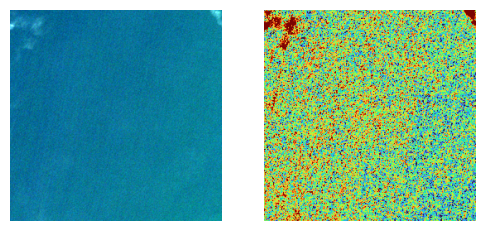

In [26]:
# Investigate RGB vs AMEI of single mucilage patches

def show_rgb(patch, eps=1e-6, ax=None):
    """
    Visualize patch as stretched RGB (B4,B3,B2).
    Assumes patch order: [B1, B2, B3, B4, ...]
    so B2=green, B3=red, B4=NIR, etc.
    """
    # Extract bands
    red   = patch[:, :, 2]  # B4
    green = patch[:, :, 1]  # B3
    blue  = patch[:, :, 0]  # B2

    # Stack to RGB
    rgb = np.dstack([red, green, blue])

    # Contrast stretch (percentile clipping)
    p2, p98 = np.nanpercentile(rgb, (2, 98))
    rgb = np.clip((rgb - p2) / (p98 - p2 + eps), 0, 1)

    if ax is None:
        ax = plt.gca()
    ax.imshow(rgb)
    ax.axis("off")
    return ax

idx = 858
fig, axs = plt.subplots(1, 2, figsize=(6, 6))
row = mucilage.loc[idx]
patch_id = idx
show_rgb(patches[patch_id], ax=axs[0])
show_amei(patches[patch_id], ax=axs[1])

# Apply SAM on mucilaage patches

In [ ]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import cv2

# Use CPU automatically
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Load smaller model checkpoint (ViT-B for CPU)
sam = sam_model_registry["vit_b"](checkpoint="/home/ubuntu/mucilage_pipeline/sam_vit_b_01ec64.pth")
sam.to(device=DEVICE)

In [ ]:
labels_corrected = pd.read_csv("labels_corrected.csv")
mucilage = labels_corrected[labels_corrected['label'] == 'mucilage']

# Load patch
row = mucilage.loc[16]
patch_id = int(row["index"])
patch = patches[patch_id]

red   = patch[:, :, 2]  # B4
green = patch[:, :, 1]  # B3
blue  = patch[:, :, 0]  # B2
rgb = np.dstack([red, green, blue])

p2, p98 = np.nanpercentile(rgb, (2, 98))
rgb = np.clip((rgb - p2) / (p98 - p2 + 1e-6), 0, 1)

image = (rgb * 255).astype(np.uint8)

# Generate masks automatically
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(rgb)

print(f"Generated {len(masks)} masks")

In [ ]:
import random
overlay = image.copy()

for mask_dict in masks:
    mask = mask_dict['segmentation']  # boolean mask
    # Generate random color for each mask
    color = np.array([random.randint(0, 255) for _ in range(3)], dtype=np.uint8)
    overlay[mask] = 0.1 * overlay[mask] + 0.9 * color  # blend mask with image

overlay = overlay.astype(np.uint8)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(6, 6))
axes[0].imshow(image)
axes[0].set_title("Original RGB Image")
axes[0].axis("off")

axes[1].imshow(overlay)
axes[1].set_title("RGB Image with SAM Masks")
axes[1].axis("off")

plt.show()

# Check AMEI on algae

In [ ]:
labels_corrected = pd.read_csv("/home/ubuntu/mucilage_pipeline/mucilage-detection/src/labels_corrected.csv")
algae = labels_corrected[labels_corrected['label'] == 'algae']

# Grid parameters
ncols = 10
nrows = int(np.ceil(len(algae) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))

for ax, (row_idx, row) in zip(axes.ravel(), algae.iterrows()):
    patch_id = int(row["index"])
    current_label = row["label"]
    show_amei(patches[patch_id], ax=ax)
    ax.set_title(f"id:{patch_id} - ax:{row_idx}", fontsize=8)

# Hide empty subplots if any
for ax in axes.ravel()[len(algae):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Investigate RGB vs AMEI of single mucilage patches

def show_rgb(patch, eps=1e-6, ax=None):
    """
    Visualize patch as stretched RGB (B4,B3,B2).
    Assumes patch order: [B1, B2, B3, B4, ...]
    so B2=green, B3=red, B4=NIR, etc.
    """
    # Extract bands
    red   = patch[:, :, 2]  # B4
    green = patch[:, :, 1]  # B3
    blue  = patch[:, :, 0]  # B2

    # Stack to RGB
    rgb = np.dstack([red, green, blue])

    # Contrast stretch (percentile clipping)
    p2, p98 = np.nanpercentile(rgb, (2, 98))
    rgb = np.clip((rgb - p2) / (p98 - p2 + eps), 0, 1)

    if ax is None:
        ax = plt.gca()
    ax.imshow(rgb)
    ax.axis("off")
    return ax

fig, axs = plt.subplots(1, 2, figsize=(6, 6))
row = algae.loc[427]
patch_id = int(row["index"])
show_rgb(patches[patch_id], ax=axs[0])
show_amei(patches[patch_id], ax=axs[1])